In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore") 
sns.set_style("darkgrid", {"grid.color": ".6", 
                           "grid.linestyle": ":"})

from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline 
from sklearn.linear_model import Lasso

from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import GridSearchCV


In [94]:
data = pd.read_csv('./data/gold_price_data.csv')
print(data)

           Date          SPX         GLD        USO      SLV   EUR/USD
0      1/2/2008  1447.160034   84.860001  78.470001  15.1800  1.471692
1      1/3/2008  1447.160034   85.570000  78.370003  15.2850  1.474491
2      1/4/2008  1411.630005   85.129997  77.309998  15.1670  1.475492
3      1/7/2008  1416.180054   84.769997  75.500000  15.0530  1.468299
4      1/8/2008  1390.189941   86.779999  76.059998  15.5900  1.557099
...         ...          ...         ...        ...      ...       ...
2285   5/8/2018  2671.919922  124.589996  14.060000  15.5100  1.186789
2286   5/9/2018  2697.790039  124.330002  14.370000  15.5300  1.184722
2287  5/10/2018  2723.070068  125.180000  14.410000  15.7400  1.191753
2288  5/14/2018  2730.129883  124.489998  14.380000  15.5600  1.193118
2289  5/16/2018  2725.780029  122.543800  14.405800  15.4542  1.182033

[2290 rows x 6 columns]


In [95]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB


Handle missing data

In [96]:
data.isnull().sum()

Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64

Correlation Between Columns

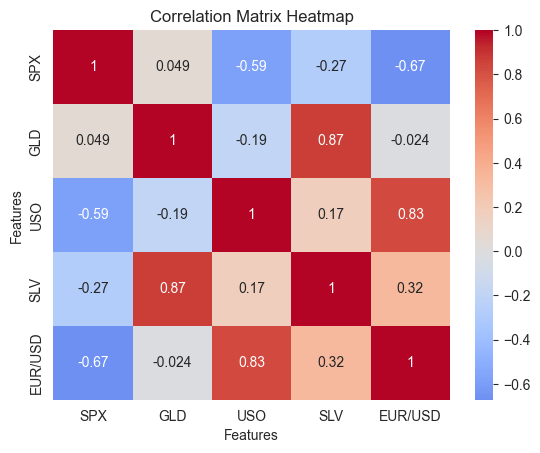

In [97]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['number'])

# Calculate the correlation matrix
correlation = numeric_data.corr()

# Create the heatmap
sns.heatmap(correlation, cmap='coolwarm', center=0, annot=True)

# Set title and axis labels
plt.title('Correlation Matrix Heatmap')
plt.xlabel('Features')
plt.ylabel('Features')

# Show the plot
plt.show()


Drop SlV column

In [98]:
data.drop("SLV", axis=1, inplace=True)

Observe the chnager in Gold pricewith each years

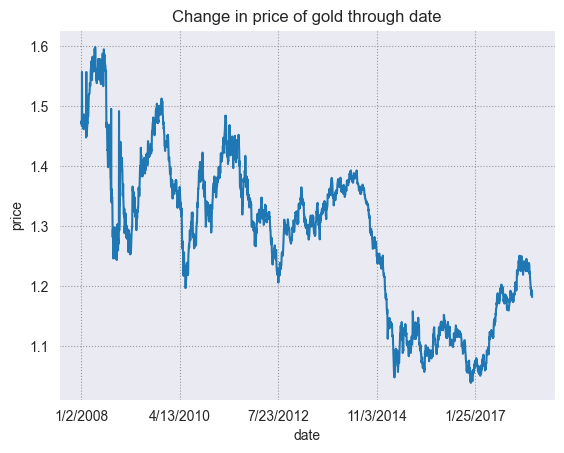

In [99]:
# reset the index to date column
data.set_index("Date", inplace=True)
data["EUR/USD"].plot()
plt.title("Change in price of gold through date")

plt.xlabel("date")
plt.ylabel("price")

plt.show()

Trending Gold price using moving avarages

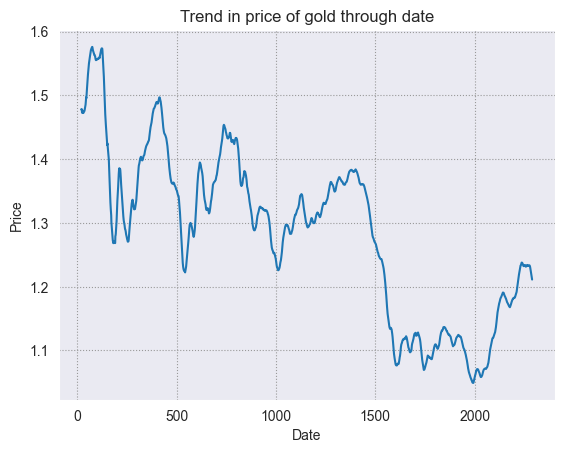

In [100]:
data["price_trend"] = data["EUR/USD"].rolling(window=20).mean()

data.reset_index("Date", inplace=True)

data["price_trend"].loc[20:].plot()

plt.title("Trend in price of gold through date")

plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

Distribution of columns

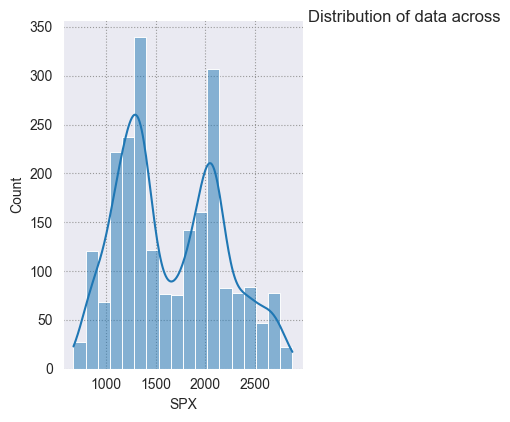

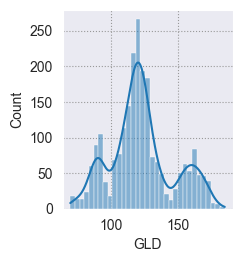

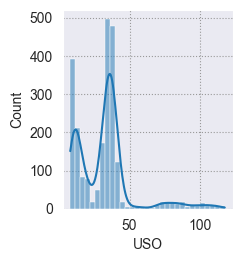

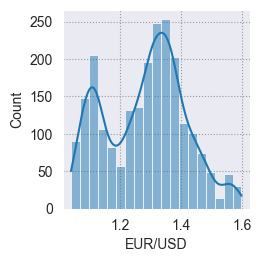

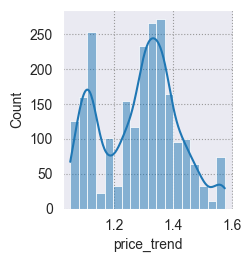

In [101]:
fig = plt.figure(figsize=(8,8))

fig.suptitle("Distribution of data across")
temp = data.drop("Date", axis=1).columns.tolist()

for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.histplot(data=data, x=item, kde=True)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.show()

Check the skewness of each column

In [102]:
print(data.drop("Date", axis=1).skew(axis=0, skipna=True))

SPX            0.300362
GLD            0.334138
USO            1.699331
EUR/USD       -0.005292
price_trend   -0.029588
dtype: float64


In [103]:
# apply saquare root transformation
# on the skewed dataset
data["USO"] = data["USO"]\
    .apply(lambda x: np.sqrt(x))

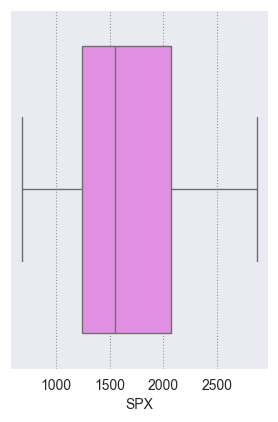

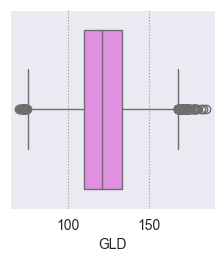

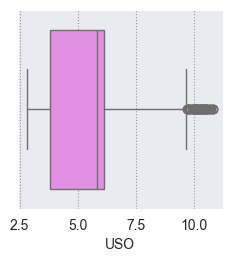

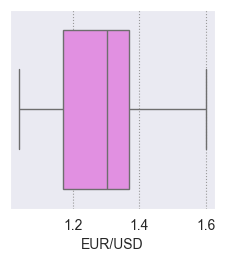

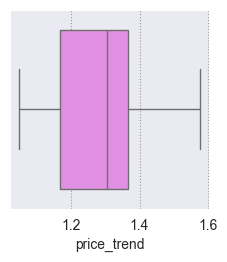

In [104]:
fig = plt.figure(figsize=(8,8))
temp = data.drop("Date", axis=1).columns.tolist()

for i, item in enumerate(temp):
    plt.subplot(2, 3, i+1)
    sns.boxplot(data=data, x=item, color='violet')
    
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.0)
    plt.show()

Create a function to normalize the outlier present in the column

In [105]:
def outlier_removal(column):
    upper_limit = column.quantile(.95)
    lower_limit = column.quantile(.05)
    
    column.loc[(column > upper_limit)] = upper_limit
    column.loc[(column < lower_limit)] = lower_limit
    
    return column

In [106]:
# Normalize outliers in columns except Date

data[['SPX', 'GLD', 'USO', 'EUR/USD']] = \
    data[['SPX', 'GLD', 'USO', 'EUR/USD']].apply(outlier_removal)

Modeling the Data

In [107]:
# select the features and target variable
X = data.drop(['Date', 'EUR/USD'], axis=1)

y = data['EUR/USD']
# dividing dataset in to train test
x_train, x_test,\
    y_train, y_test = train_test_split(X, y,
                                       test_size=0.2)

Scaling the Data 

In [108]:
# Create an instance of the StandardScaler
scaler = StandardScaler()

# Fit the StandardScaler on the training dataset
scaler.fit(x_train)

# Transform the training dataset
# using the StandardScaler
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

Lasso Regression

In [109]:
# Impute missing values using SimpleImputer
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean') # Replace NaNs with the mean of each column

# Fit and transform the imputer on the scaled training data
x_train_scaled = imputer.fit_transform(x_train_scaled)

# Transform the scaled test data using the trained imputer
x_test_scaled = imputer.transform(x_test_scaled)

# Create a PolynomialFeatures object of degree 2
poly = PolynomialFeatures(degree=2)

# Create a Lasso object
lasso = Lasso()

# Define a dictionary of parameter
#values to search over
param_grid = {'lasso__alpha': [1e-4, 1e-3, 1e-2,
                            1e-1, 1, 5, 10, 
                            20, 30, 40]}

# Create a pipeline that first applies 
# polynomial features and then applies Lasso regression
pipeline = make_pipeline(poly, lasso)

# Create a GridSearchCV object with 
#the pipeline and parameter grid
lasso_grid_search = GridSearchCV(pipeline,
                                param_grid, 
                                scoring='r2', cv=3)

# Fit the GridSearchCV object to the training data
lasso_grid_search.fit(x_train_scaled, y_train)

# Predict the target variable using
# the fitted model and the test data
y_pred = lasso_grid_search.predict(x_train_scaled)

# Compute the R-squared of the fitted model on the train data
r2 = r2_score(y_train, y_pred)

# Print the R-squared
print("R-squared: ", r2)

# Print the best parameter values and score
print('Best parameter values: ',
    lasso_grid_search.best_params_)
print('Best score: ',
    lasso_grid_search.best_score_)

R-squared:  0.9659854576668815
Best parameter values:  {'lasso__alpha': 0.0001}
Best score:  0.9644238590462805


RandomForestRegressor for Regression

In [110]:
# Insiate param grid for which to search
param_grid = {'n_estimators': [50, 80, 100],
              'max_depth': [3, 5, 7]}

# create instance of the Randomforest regressor
rf = RandomForestRegressor()

# Define Girdsearch with random forest
# object parameter grid scoring and cv
rf_grid_search = GridSearchCV(rf, param_grid, scoring='r2', cv=2)

# Fit the GridSearchCV object to the training data

rf_grid_search.fit(x_train_scaled, y_train)

# Print the best parameter values and score
print('Best parameter values: ', rf_grid_search.best_params_)
print('Best score: ', rf_grid_search.best_score_)

Best parameter values:  {'max_depth': 7, 'n_estimators': 80}
Best score:  0.9747968975194762


In [111]:
# Compute the R-squared of the
# fitted model on the test data
r2 = r2_score(y_test,
              rf_grid_search.predict(x_test_scaled))

# Print the R-squared
print("R-squared:", r2)

R-squared: 0.9786875544711723


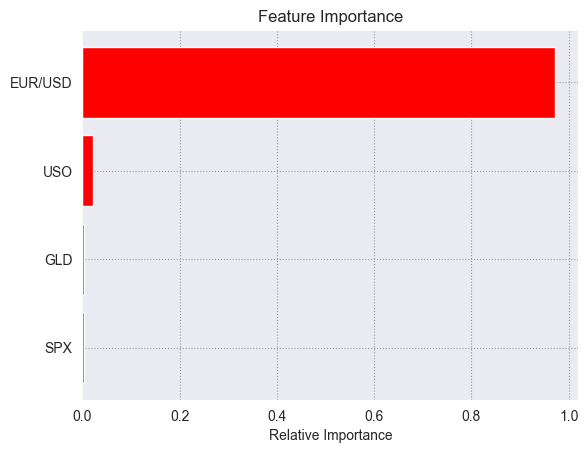

In [112]:
features = data.drop("Date", axis=1).columns

# store the importance of the feature
importances = rf_grid_search.best_estimator_.\
    feature_importances_


indices = np.argsort(importances)

# title of the graph
plt.title('Feature Importance')

plt.barh(range(len(indices)),
         importances[indices],
         color='red',
         align='center')

# plot bar chart
plt.yticks(range(len(indices)),
           [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()